In [74]:
# %pip uninstall -y numpy
%pip install numpy matplotlib
%pip install filterpy coloredlogs pytorch_lightning transformers lightning


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [75]:
!python -c "import numpy; print(numpy.__version__)"

1.26.4


# Imports

In [76]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collect_data import collect_data
from models import GPT2
from core import Config
from train import train_gpt2
from core import setup_train
import os
from create_plots_with_zero_pred import create_plots, convergence_plots, load_preds
import argparse
import wandb
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from log_log_fit import loglogfit, loglinfit, loss, model_function, model_function_loglin, loglogfit_regularized, closed_form_loglin, plot_closed_form_loglin_err
from scipy.optimize import curve_fit, minimize
import sympy as sp
import pickle
from check_ecdf import get_empirical_cdf

## Least Squares Problem with Gradient Descent

In [77]:
def f(w,x,y):
    return w.T@x.T@x@w - 2*x.T@y@w + y.T@y

def df(w,x,y):
    return 2*x.T@x@w - 2*x.T@y

def gradient_descent(init_w, x, y, alpha):
    pred_errs = []
    pred_err = np.Inf
    w = init_w
    print("analytical_error", analytical_error(x,y))
    while pred_err > analytical_error(x,y):
        print("df(w,x,y)", df(w,x,y))
        w = w - alpha*df(w,x,y)
        pred_err = prediction_error(w,x,y)[0][0]
        print("pred_err", pred_err)
        pred_errs.append(pred_err)
    return w, pred_errs

def analytical_solution(x,y):
    return np.linalg.inv(x.T@x)@x.T@y

def prediction_error(w,x,y):
    return (x@w-y).T@(x@w-y)

def analytical_error(x,y):
    w = analytical_solution(x,y)
    return prediction_error(w,x,y)

In [78]:

#create a list of x values from 0 to 100
x = list(range(100))
#make x an np array
x = np.array(x).reshape(-1,1)
#create a list of y values by the formula y = 2x + noise
y = [2*i + np.random.normal(0, 10) for i in x]


init_w = np.random.rand(1)
alpha = 1e-6

w, pred_errs = gradient_descent(init_w, x, y, alpha)
print("w, gradient descent: ", w)


analytical_error [[9702.27476444]]
df(w,x,y) [[-1127525.41841533]]
pred_err 123780.63691637103
df(w,x,y) [[-387079.47614198]]
pred_err 23146.967587233114
df(w,x,y) [[-132884.38415954]]
pred_err 11286.797558151182
df(w,x,y) [[-45619.20908197]]
pred_err 9889.018523992432
df(w,x,y) [[-15661.07447784]]
pred_err 9724.283429677354
df(w,x,y) [[-5376.44686824]]
pred_err 9704.86859325771
df(w,x,y) [[-1845.73420987]]
pred_err 9702.5804598471
df(w,x,y) [[-633.64055425]]
pred_err 9702.310792135693
df(w,x,y) [[-217.52880227]]
pred_err 9702.279010477225
df(w,x,y) [[-74.67763782]]
pred_err 9702.275264853364
df(w,x,y) [[-25.63683306]]
pred_err 9702.274823413274
df(w,x,y) [[-8.80112479]]
pred_err 9702.274771387405
df(w,x,y) [[-3.02142614]]
pred_err 9702.2747652559
df(w,x,y) [[-1.03725559]]
pred_err 9702.274764533273
df(w,x,y) [[-0.35608985]]
pred_err 9702.274764448106
df(w,x,y) [[-0.12224564]]
pred_err 9702.274764438072
df(w,x,y) [[-0.04196693]]
pred_err 9702.274764436886
df(w,x,y) [[-0.01440725]]
pred

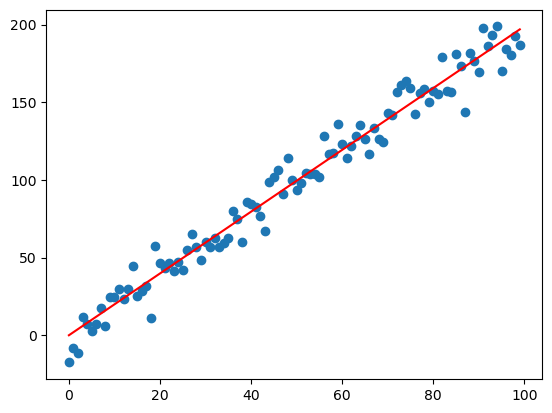

In [79]:
#plot the data
plt.scatter(x, y)
#plot the line of best fit
plt.plot(x, w*x, color='red')
plt.show()

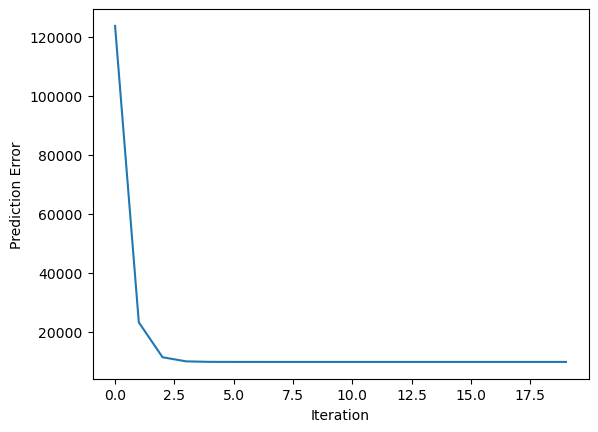

In [80]:
#plot pred_errs
# make a list from 0 to len(pred_errs)
x_plo = list(range(len(pred_errs)))
plt.plot(x_plo, pred_errs)
plt.xlabel("Iteration")
plt.ylabel("Prediction Error")
plt.show()


pred_errs is now the y_values that we want to check

step_size: step=40000.ckpt
err_lss_load keys: odict_keys(['MOP', 'MOP_analytical', 'Zero'])
len of irreducible_error_load 24


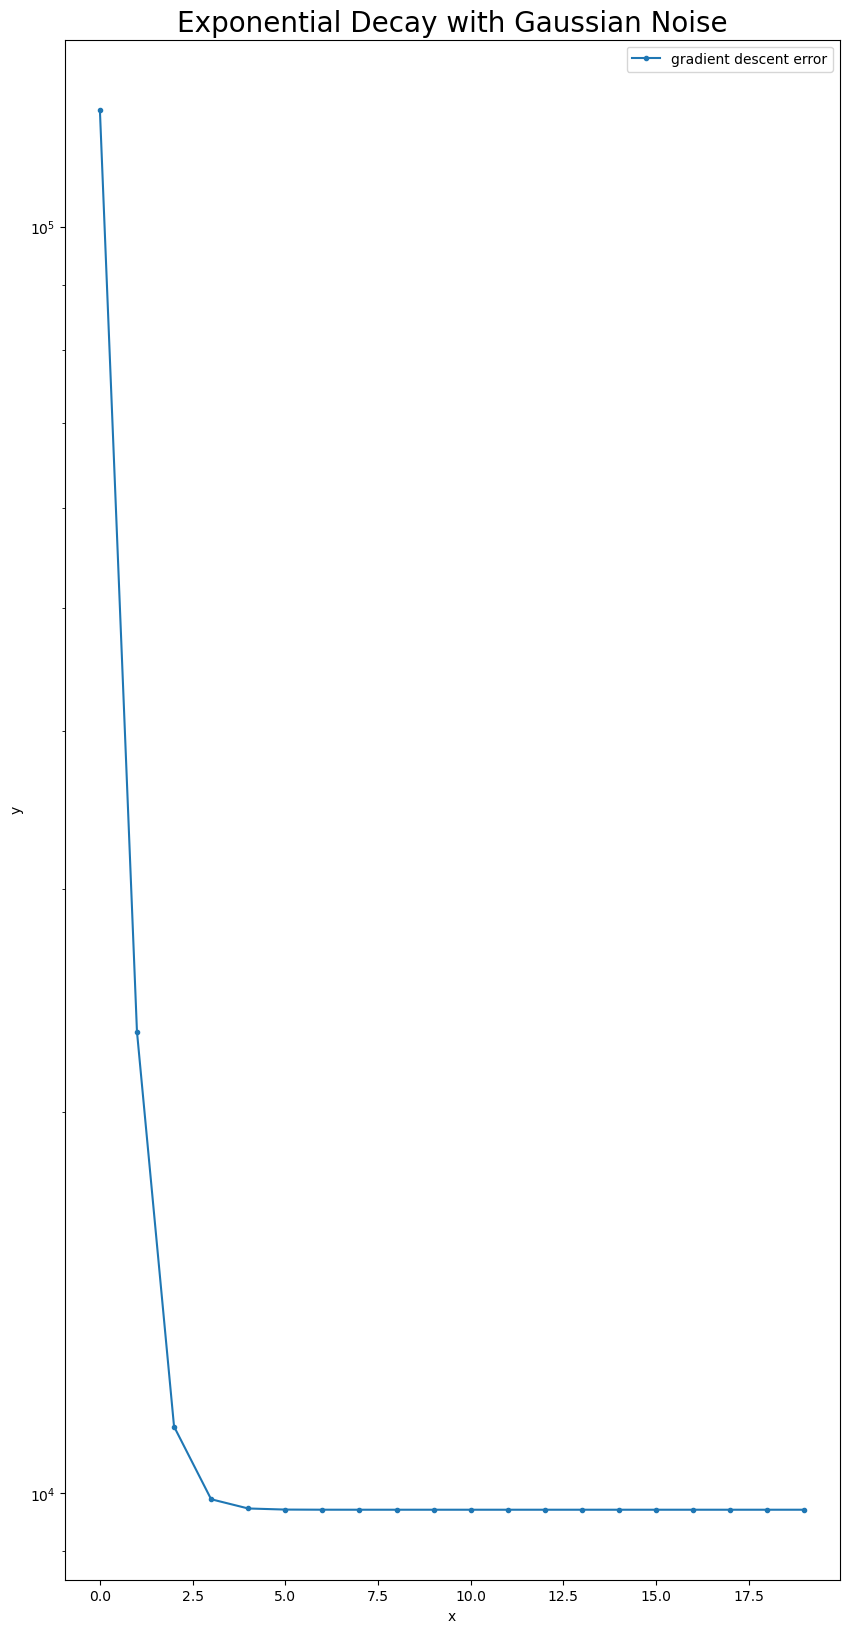

In [81]:
def save_figure(fig, config, kfnorm, olsnorm, yax, xax, subtracted, err=False, ratios=False, cdf=False, eval_start=None):
    
    fig.text(0.5, 0, "The error bars are 3*std.", ha='center', va='bottom', fontsize=12)
    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()
    #get the parent directory of the ckpt_path
    parent_dir = os.path.dirname(config.ckpt_path)

    #get the parent directory of the parent directory
    parent_parent_dir = os.path.dirname(parent_dir)
    os.makedirs(parent_parent_dir + "/figures", exist_ok=True)
    fig.savefig(parent_parent_dir + f"/figures/{config.dataset_typ}" + config.C_dist + "_system_conv_checks" + ("_KF_normalized" if kfnorm else ("_OLS_normalized" if olsnorm else "")) + ("_subtracted" if subtracted else "") + ("_ylog" if yax == "log" else "") + ("_xlog" if xax == "log" else "") + ("_fit_err" if err else "") + ("_dummy_ratios" if ratios else "") + ("_cdf" if cdf else "") + ("_" + str(eval_start) if eval_start else "")+ ".png")
    return None

def save_figure_c(fig, config, kfnorm, olsnorm, yax, xax, subtracted):
    
    fig.text(0.5, 0, "The error bars are 3*std.", ha='center', va='bottom', fontsize=12)
    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()
    #get the parent directory of the ckpt_path
    parent_dir = os.path.dirname(config.ckpt_path)

    #get the parent directory of the parent directory
    parent_parent_dir = os.path.dirname(parent_dir)
    os.makedirs(parent_parent_dir + "/figures", exist_ok=True)
    fig.savefig(parent_parent_dir + f"/figures/{config.dataset_typ}" + config.C_dist + "_find_opt_c" + ("_KF_normalized" if kfnorm else ("_OLS_normalized" if olsnorm else "")) + ("_subtracted" if subtracted else "") + ("_ylog" if yax == "log" else "") + ("_xlog" if xax == "log" else "") + ".png")
    return None

def get_opposite_color(hex_color):
    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)

    # Calculate the complementary color
    comp_r = 255 - r
    comp_g = 255 - g
    comp_b = 255 - b

    # Convert the complementary RGB back to hex
    comp_hex = f'#{comp_r:02x}{comp_g:02x}{comp_b:02x}'

    return comp_hex

def fit_curves_err(fit_y, y_values, x_values, rem, ax_err, plot_label, t, ts, sys, eval_start=24, past_y_max=0):
    #compute the element-wise squared error between y_values and yfit_optc
    opt_err = (y_values - fit_y)**2
    print("opt_err", opt_err)
    print("opt_err shape", opt_err.shape)

    # if eval_start != rem:
    #     raise ValueError("eval_start not to rem which is: ", rem)
    #compute the mean value of opt_err after the index rem
    mean_opt_err = np.mean(opt_err[eval_start:])
    print("mean_opt_err", mean_opt_err)

    #plot the error vs x_values on ax_err on a linear linear scale. Have the curve entries before and after rem be different colors
    ax_err[t].plot(x_values, opt_err, label=plot_label + " t="+str(ts[t]), marker='.')

    #if plot label contains "Least Squares Optimal c", plot a vertical line at x = rem
    if "Least Squares Optimal c" in plot_label:
        #plot a vertical line at x = rem
        ax_err[t].axvline(x=x_values[rem], color='r', linestyle='--', label="Train-Test Split")

    #set x and y labels
    ax_err[t].set_xlabel("Checkpoint Step")
    ax_err[t].set_ylabel("Squared Error")

    #set the title
    ax_err[t].set_title("System " + str(sys) + ": t = " + str(ts[t]))

    #set the x-axis limits
    lower_x_limit = 0 #50000
    upper_x_limit = x_values[-1]
    ax_err[t].set_xlim([lower_x_limit, upper_x_limit])
    # Filter the data based on the new x-axis limits
    x_values = np.array(x_values)
    opt_err = np.array(opt_err)
    filtered_y = opt_err[(x_values >= lower_x_limit) & (x_values <= upper_x_limit)]
    if filtered_y.max() > past_y_max and np.isfinite(filtered_y.max()):
        ax_err[t].set_ylim([0, filtered_y.max()])
        ax_err[t].figure.canvas.draw()
        past_y_max = filtered_y.max()

    return ax_err, past_y_max, mean_opt_err




config = Config()

ts = [0]
t = ts[0]
sys = 0

#load the prediction errors from the step=40000 prediction_errors file
num_systems = config.num_val_tasks
run_deg_kf_test = False
excess = False
config.override("ckpt_path", "/Users/sultandaniels/Documents/Transformer_Kalman/outputs/GPT2/240619_070456.1e49ad_upperTriA_gauss_C/checkpoints/step=40000.ckpt")
err_lss_load, irreducible_error_load, fir_bounds, rnn_errors, rnn_an_errors = load_preds(run_deg_kf_test, excess, num_systems, config)
print("len of irreducible_error_load", len(irreducible_error_load))


#set x_values to be 4000 to 192000 in increments of 4000
x_values = x_plo

#set the y_values to be exponential decay with a=-0.5, b=1, c=1 with added gaussian noise
y_values = pred_errs

fig_curve, ax_curve = plt.subplots(1, 1, figsize=(10, 20))
ax_curve.plot(x_values, y_values, label="gradient descent error", marker=".")
ax_curve.set_xlabel("x")
ax_curve.set_ylabel("y")
ax_curve.set_title("Exponential Decay with Gaussian Noise")
ax_curve.set_yscale("log")
ax_curve.legend()



yfit_optc [65555.23936099 18514.07324348 11092.4784049   9921.58757684
  9736.85836957  9707.71399573  9703.11594359  9702.39051769
  9702.27606864  9702.25801223  9702.2551635   9702.25471407
  9702.25464316  9702.25463197  9702.25463021  9702.25462993
  9702.25462988  9702.25462988  9702.25462988  9702.25462988]


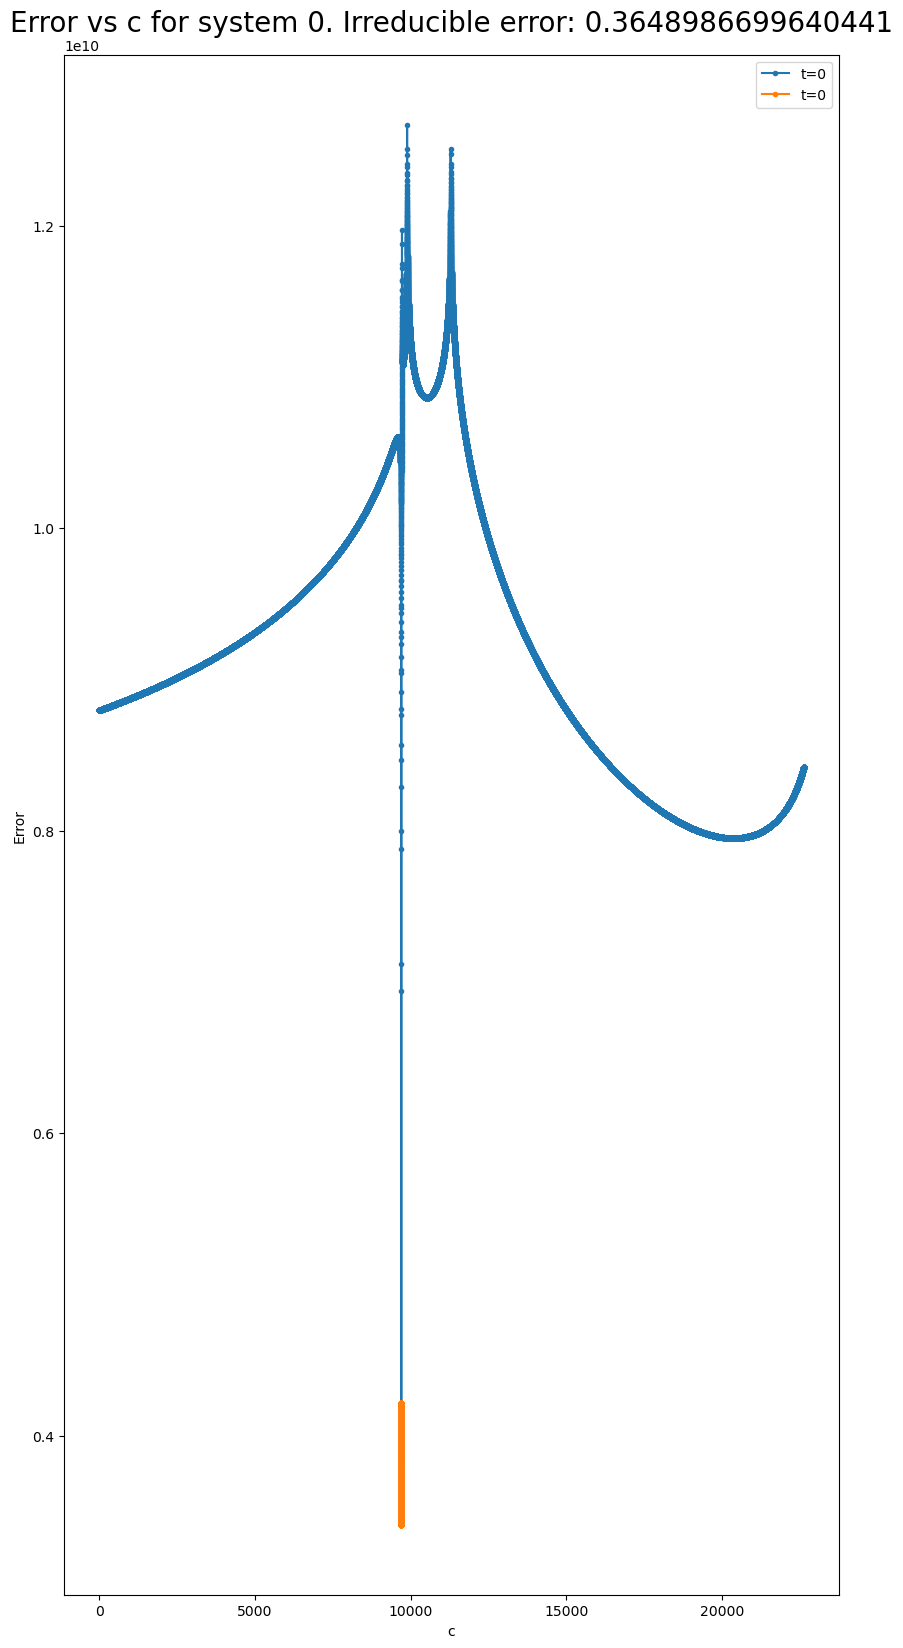

In [82]:

#keep only the first rem elements of x_values and y_values
rem = int(np.ceil(len(x_values)/2))
eval_start = rem #set eval_start to the last element of x_values
x_train = x_values[:rem]
y_train = y_values[:rem]

# #analytical
# y_an_values = y_an_values[rem:]

##### create a helper function for log optimization #######################################
# closed form solution for loglin fit
#create figure and axc
fig, axc = plt.subplots(1, 1, figsize=(10, 20))
axc, a_vals, b_vals, c_vals, err_vals, err_lin_vals = plot_closed_form_loglin_err(x_train, y_train, irreducible_error_load[sys], [axc], sys, ts[t], 0.0, np.mean(y_train))

# #analytical
# axc_an, a_vals_an, b_vals_an, c_vals_an, err_vals_an, err_lin_vals_an = plot_closed_form_loglin_err(x_values, y_an_values, irreducible_error_load[sys], axc_an, sys, ts[t], 0.0, np.mean(y_an_values))

# get index for minimum lin error
min_err_lin_idx = np.argmin(err_lin_vals)

# #analytical
# min_err_lin_idx_an = np.argmin(err_lin_vals_an)

#get min c value
min_c = c_vals[min_err_lin_idx]
interval = 7e-3
axc, a_vals, b_vals, c_vals, err_vals, err_lin_vals = plot_closed_form_loglin_err(x_train, y_train, irreducible_error_load[sys], axc, sys, ts[t], min_c - interval, min_c + interval)

# get index for minimum lin error
min_err_lin_idx = np.argmin(err_lin_vals)

#get fitted y values from model function
yfit_optc = model_function_loglin(x_values, a_vals[min_err_lin_idx], b_vals[min_err_lin_idx], c_vals[min_err_lin_idx])
print("yfit_optc", yfit_optc)

opt_err [3.39019692e+09 2.14637100e+07 3.77599333e+04 1.06074320e+03
 1.58129113e+02 8.09631521e+00 2.86742837e-01 6.35616455e-03
 8.65442420e-06 2.97653077e-04 3.86512070e-04 4.02296177e-04
 4.04898817e-04 4.05320051e-04 4.05387690e-04 4.05398498e-04
 4.05400220e-04 4.05400493e-04 4.05400537e-04 4.05400543e-04]
opt_err shape (20,)
mean_opt_err 0.00040314150969442077
lstsq_mean_err 0.00040314150969442077


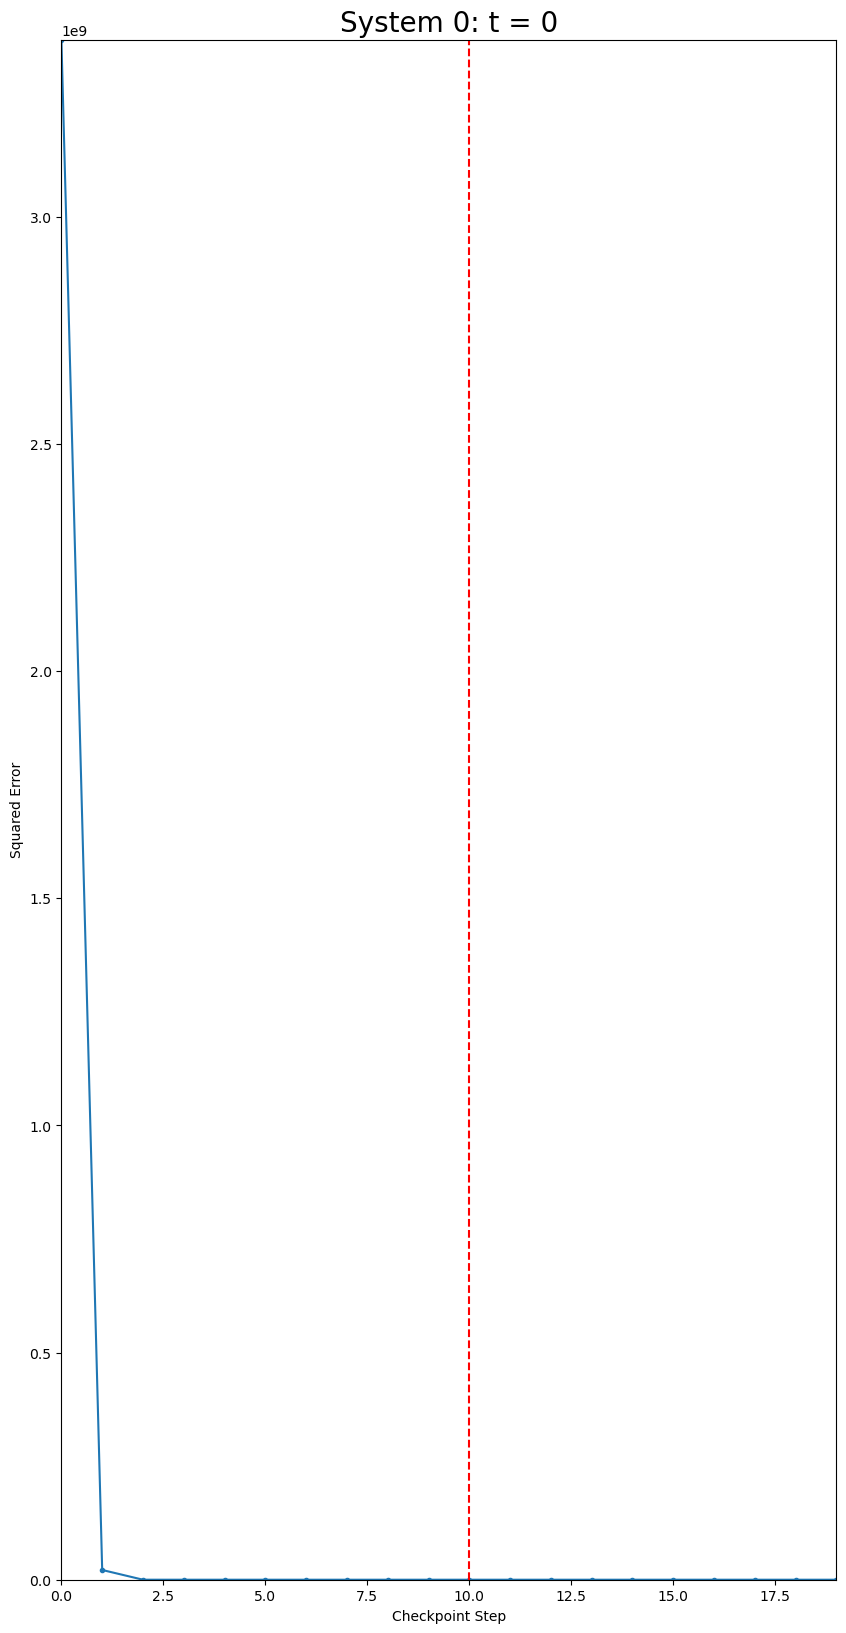

In [83]:

###########################################################################################
#create figure and ax_err
fig_err, ax_err = plt.subplots(1, 1, figsize=(10, 20))
#plot error
ax_err, p, lstsq_mean_err = fit_curves_err(yfit_optc, y_values, x_values, rem, [ax_err], "Least Squares Optimal c=%g, a=%g, b=%g" % (c_vals[min_err_lin_idx], a_vals[min_err_lin_idx], b_vals[min_err_lin_idx]), t, ts, sys, eval_start=eval_start)
print("lstsq_mean_err", lstsq_mean_err)

In [84]:


# #analytical
# min_c_an = c_vals_an[min_err_lin_idx_an]
# axc_an, a_vals_an, b_vals_an, c_vals_an, err_vals_an, err_lin_vals_an = plot_closed_form_loglin_err(x_values, y_an_values, irreducible_error_load[sys], axc_an, sys, ts[t], min_c_an - interval, min_c_an + interval)

# #analytical
# yfit_optc_an = model_function_loglin(x_values, a_vals_an[min_err_lin_idx_an], b_vals_an[min_err_lin_idx_an], c_vals_an[min_err_lin_idx_an])



In [85]:
#initial guess for the parameters
initial_guess = [a_vals[min_err_lin_idx], b_vals[min_err_lin_idx], c_vals[min_err_lin_idx]]

# Fit a line to the data (line on log-log scale)
y_fit_loglog, a_loglog, b_loglog, c_loglog = loglogfit(x_train, x_values, y_train, initial_guess)
print("y_fit_loglog", y_fit_loglog)

ax_err, p, loglog_mean_err = fit_curves_err(y_fit_loglog, y_values, x_values, rem, ax_err, "y = e^bx^a + c, c=%g, a=%g, b=%g" % (c_loglog, a_loglog, b_loglog), t, ts, sys, past_y_max=p, eval_start=eval_start)


y_fit_loglog [           inf 65555.23936099 25231.68872507 17047.0615405
 14020.07800991 12561.8726256  11744.41397748 11238.51113657
 10902.787671   10668.1150725  10497.34641263 10369.03119463
 10270.05918237 10192.04038784 10129.39732044 10078.3015344
 10036.05234599 10000.69912722  9970.80368166  9945.28623088]
opt_err [           inf 1.79846151e+09 1.94459990e+08 5.12375798e+07
 1.84538511e+07 8.16247204e+06 4.16908411e+06 2.35991150e+06
 1.44122104e+06 9.32846534e+05 6.32138832e+05 4.44564128e+05
 3.22379144e+05 2.39870366e+05 1.82433678e+05 1.41396132e+05
 1.11407474e+05 8.90571003e+04 7.21077794e+04 5.90545728e+04]
opt_err shape (20,)
mean_opt_err 229440.92060182212


/Users/sultandaniels/Documents/Transformer_Kalman/mop_modifications/streamlined_mop/src/log_log_fit.py:7: RuntimeWarning: divide by zero encountered in power
  return c + np.exp(b) * x**a
/Users/sultandaniels/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [86]:

# Fit a line to the data (line on log-linear scale)
y_fit_loglin, a_loglin, b_loglin, c_loglin = loglinfit(x_train, x_values, y_train, initial_guess)

ax_err, p, loglin_mean_err = fit_curves_err(y_fit_loglin, y_values, x_values, rem, ax_err, "y = e^be^(ax) + c, c=%g, a=%g, b=%g" % (c_loglin, a_loglin, b_loglin), t, ts, sys, past_y_max=p, eval_start=eval_start)



opt_err [0.00000000e+00 0.00000000e+00 3.30872245e-24 1.32348898e-23
 1.32348898e-23 1.32348898e-23 3.30872245e-24 1.32348898e-23
 0.00000000e+00 3.30872245e-24 0.00000000e+00 1.32348898e-23
 3.30872245e-24 1.32348898e-23 3.30872245e-24 2.97785021e-23
 3.30872245e-24 1.32348898e-23 2.97785021e-23 3.30872245e-24]
opt_err shape (20,)
mean_opt_err 1.1249656330721176e-23


In [87]:


# Fit a regularized line to the data
# Regularization strength
lambda_reg = 1e-2
a_opt, b_opt, c_opt = loglogfit_regularized(initial_guess, x_train, y_train, lambda_reg)

# Generate y-values based on the optimized model
fitted_y_values_opt = model_function(x_values, a_opt, b_opt, c_opt)

# ax_err, p, loglogreg_mean_err = fit_curves_err(fitted_y_values_opt, y_values, x_values, rem, ax_err, "Regularized Fit y = e^bx^a, c=%g, a=%g, b=%g" % (c_opt, a_opt, b_opt), t, ts, sys)


/Users/sultandaniels/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [88]:


#dumb predictor
last_val = y_train[-1]
yfit_dumb = np.full(len(x_values), last_val)
ax_err, p, dumb_mean_err = fit_curves_err(yfit_dumb, y_values, x_values, rem, ax_err, "Dumb Predictor", t, ts, sys, past_y_max=p, eval_start=eval_start)



opt_err [1.30138726e+10 1.80759752e+08 2.51071090e+06 3.48730448e+04
 4.84359319e+02 6.72535221e+00 9.31439842e-02 1.26218779e-03
 1.40296981e-05 0.00000000e+00 1.94869353e-07 2.43508653e-07
 2.49597627e-07 2.50320194e-07 2.50405422e-07 2.50415464e-07
 2.50416651e-07 2.50416790e-07 2.50416804e-07 2.50416810e-07]
opt_err shape (20,)
mean_opt_err 2.440783767866932e-07


In [89]:

#divide the mean errors by the dumb mean error
lstsq_mean_err = lstsq_mean_err/dumb_mean_err
loglog_mean_err = loglog_mean_err/dumb_mean_err
loglin_mean_err = loglin_mean_err/dumb_mean_err
# loglogreg_mean_err = loglogreg_mean_err/dumb_mean_err
dumb_mean_err = dumb_mean_err/dumb_mean_err

# add lstsq_mean_err to the err_dict_list
lstsq = lstsq_mean_err

# add loglog_mean_err to the err_dict_list
loglog = loglog_mean_err

# add loglin_mean_err to the err_dict_list
loglin = loglin_mean_err

# # add loglogreg_mean_err to the err_dict_list
# err_dict_list[t]["loglogreg"].append(loglogreg_mean_err)

# add dumb_mean_err to err_dict_list
dumb = dumb_mean_err

#print the mean errors
print("lstsq_mean_err", lstsq_mean_err)
print("loglog_mean_err", loglog_mean_err)
print("loglin_mean_err", loglin_mean_err)
# print("loglogreg_mean_err", loglogreg_mean_err)
print("dumb_mean_err", dumb_mean_err)



lstsq_mean_err 1651.6887526121873
loglog_mean_err 940029688915.6094
loglin_mean_err 4.609034392486377e-17
dumb_mean_err 1.0
